# Super-resolution using Stable Diffusion v2 Upscalers

To improve the performance of our LDM models, we will use a method called "noise conditioning augmentation" (introduced in [2] and used in Stable Diffusion v2.0 and Imagen Video [3]). During the training, we add noise to the low-resolution images using a random signal-to-noise ratio, and we condition the diffusion models on the amount of noise added. At sampling time, we use a fixed signal-to-noise ratio, representing a small amount of augmentation that aids in removing artefacts in the samples.


[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Ho et al. "Cascaded diffusion models for high fidelity image generation" https://arxiv.org/abs/2106.15282

[3] - Ho et al. "High Definition Video Generation with Diffusion Models" https://arxiv.org/abs/2210.02303

## Set up environment using Colab


In [1]:
!pip install monai
!pip install monai-generative
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## Set up imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmphyit8_ak


## Download the training set

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]

MedNIST.tar.gz: 59.0MB [00:00, 111MB/s]                            

2024-03-20 06:55:07,506 - INFO - Downloaded: /tmp/tmphyit8_ak/MedNIST.tar.gz


2024-03-20 06:55:07,660 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-20 06:55:07,663 - INFO - Writing into directory: /tmp/tmphyit8_ak.


Loading dataset: 100%|██████████| 47164/47164 [00:34<00:00, 1352.24it/s]


## Create data loader for training set

Here, we create the data loader that we will use to train our models. We will use data augmentation and create low-resolution images using MONAI's transformations.

In [6]:
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████| 7991/7991 [00:10<00:00, 761.84it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualise examples from the training set

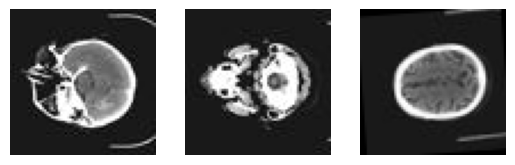

In [7]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

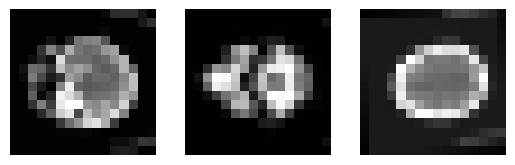

In [8]:
# Plot 3 examples from the training set in low resolution
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["low_res_image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

## Create data loader for validation set

In [9]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=4)

2024-03-20 06:56:17,023 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-20 06:56:17,025 - INFO - File exists: /tmp/tmphyit8_ak/MedNIST.tar.gz, skipped downloading.
2024-03-20 06:56:17,027 - INFO - Non-empty folder exists in /tmp/tmphyit8_ak/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 972/972 [00:02<00:00, 458.47it/s]


## Define the autoencoder network and training components

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [12]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 512, 512),
    latent_channels=3,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, num_channels=64)
discriminator = discriminator.to(device)

In [13]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.002

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.005

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 136MB/s]


In [14]:
scaler_g = GradScaler()
scaler_d = GradScaler()

## Train Autoencoder

Epoch 9: 100%|█████████████████| 250/250 [03:36<00:00,  1.16it/s, recons_loss=0.0268, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0283


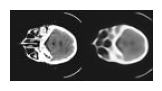

Epoch 19: 100%|████████| 250/250 [03:41<00:00,  1.13it/s, recons_loss=0.0214, gen_loss=0.353, disc_loss=0.231]


epoch 20 val loss: 0.0224


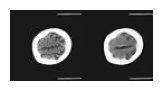

Epoch 29: 100%|█████████| 250/250 [03:43<00:00,  1.12it/s, recons_loss=0.0184, gen_loss=0.359, disc_loss=0.22]


epoch 30 val loss: 0.0202


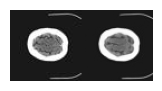

Epoch 39: 100%|████████| 250/250 [03:43<00:00,  1.12it/s, recons_loss=0.0163, gen_loss=0.324, disc_loss=0.233]


epoch 40 val loss: 0.0200


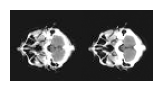

Epoch 49: 100%|████████| 250/250 [03:44<00:00,  1.11it/s, recons_loss=0.0152, gen_loss=0.312, disc_loss=0.236]


epoch 50 val loss: 0.0178


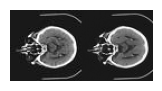

Epoch 59: 100%|████████| 250/250 [03:44<00:00,  1.11it/s, recons_loss=0.0141, gen_loss=0.307, disc_loss=0.237]


epoch 60 val loss: 0.0170


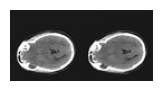

Epoch 69: 100%|████████| 250/250 [03:45<00:00,  1.11it/s, recons_loss=0.0137, gen_loss=0.301, disc_loss=0.239]


epoch 70 val loss: 0.0162


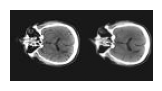

Epoch 74: 100%|████████| 250/250 [03:45<00:00,  1.11it/s, recons_loss=0.0128, gen_loss=0.301, disc_loss=0.237]


In [15]:
kl_weight = 1e-6
n_epochs = 75
val_interval = 10
autoencoder_warm_up_n_epochs = 10

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

        # ploting reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

In [16]:
import pickle
with open('autoencoderkl_chestCT_super_resolution.pkl', 'wb') as f:
    pickle.dump(autoencoderkl, f)

In [10]:
import pickle
with open('autoencoderkl_chestCT_super_resolution.pkl', 'rb') as f:
    autoencoderkl=pickle.load(f)

## Rescaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) became crucial in image-to-image translation models (such as the ones used for super-resolution). For this reason, we will compute the component-wise standard deviation to be used as scaling factor.

In [13]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))
7
print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9875608086585999


## Train Diffusion Model

In order to train the diffusion model to perform super-resolution, we will need to concatenate the latent representation of the high-resolution with the low-resolution image. For this, we create a Diffusion model with `in_channels=4`. Since only the outputted latent representation is interesting, we set `out_channels=3`.

In [14]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(256, 256, 512, 1024),
    attention_levels=(False, False, True, True),
    num_head_channels=(0, 0, 64, 64),
)
unet = unet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

As mentioned, we will use the conditioned augmentation (introduced in [2] section 3 and used on Stable Diffusion Upscalers and Imagen Video [3] Section 2.5) as it has been shown critical for cascaded diffusion models, as well for super-resolution tasks. For this, we apply Gaussian noise augmentation to the low-resolution images. We will use a scheduler `low_res_scheduler` to add this noise, with the `t` step defining the signal-to-noise ratio and use the `t` value to condition the diffusion model (inputted using `class_labels` argument).

In [15]:
low_res_scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

max_noise_level = 350

Epoch 19: 100%|█████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.67it/s, loss=0.135]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 19 val loss: 0.1407


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.72it/s]


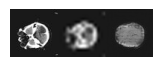

Epoch 39: 100%|█████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.67it/s, loss=0.132]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 39 val loss: 0.1335


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.54it/s]


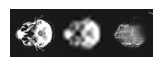

Epoch 59: 100%|██████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.67it/s, loss=0.13]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 59 val loss: 0.1452


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.15it/s]


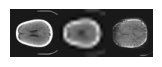

Epoch 79: 100%|█████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.68it/s, loss=0.129]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 79 val loss: 0.1258


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.63it/s]


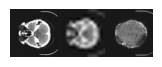

Epoch 99: 100%|█████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.68it/s, loss=0.127]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 99 val loss: 0.1186


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.52it/s]


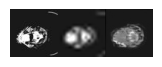

Epoch 119: 100%|████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.68it/s, loss=0.122]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 119 val loss: 0.1299


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.46it/s]


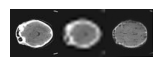

Epoch 139: 100%|████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.68it/s, loss=0.122]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 139 val loss: 0.1349


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.63it/s]


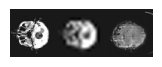

Epoch 159: 100%|████████████████████████████████████████████████| 250/250 [01:34<00:00,  2.65it/s, loss=0.122]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 159 val loss: 0.1152


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.39it/s]


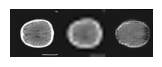

Epoch 179: 100%|████████████████████████████████████████████████| 250/250 [01:33<00:00,  2.68it/s, loss=0.122]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 179 val loss: 0.1302


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.32it/s]


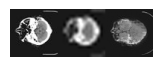

Epoch 190: 100%|████████████████████████████████████████████████▊| 249/250 [01:33<00:00,  2.66it/s, loss=0.12]


KeyboardInterrupt: 

In [16]:
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

scaler_diffusion = GradScaler()

n_epochs = 200
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        for val_step, batch in enumerate(val_loader, start=1):
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor
                    # Noise augmentation
                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 3, 16, 16)).to(device)
        low_res_noise = torch.randn((1, 1, 16, 16)).to(device)
        noise_level = 20
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=110):
            with torch.no_grad():
                with autocast(enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

In [17]:
import pickle
with open('unet_headCT_super_resolution.pkl', 'wb') as f:
    pickle.dump(unet, f)

### Plotting sampling example

In [18]:
# Sampling image during training
unet.eval()
num_samples = 3
validation_batch = first(val_loader)

images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
latents = torch.randn((num_samples, 3, 16, 16)).to(device)
low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long().to(device)
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.42it/s]


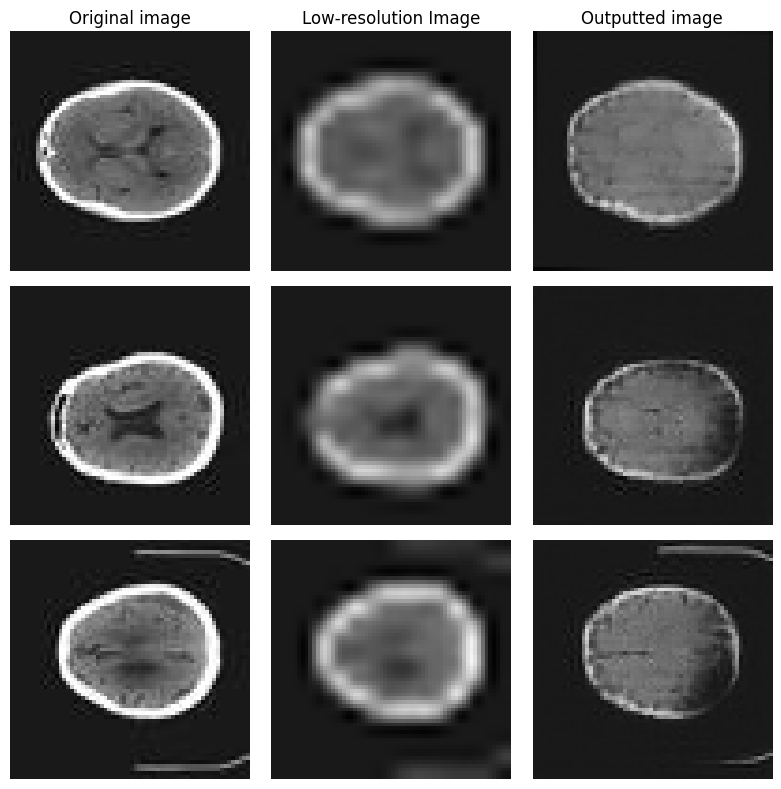

In [20]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()